In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!nvidia-smi

Sat May 13 14:59:11 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [27]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 14.6 MB/s eta 0:00:00


In [30]:
%matplotlib inline
import os
import shutil
import random
import torch
import torchvision
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from torchmetrics import ConfusionMatrix
from grad import GradCAM
from utils import deprocess_image
torch.manual_seed(0)

In [4]:
import os
import shutil
import random

classes_list = ['NORMAL', 'PNEUMONIA', 'COVID']
root_path = '/content/drive/MyDrive/DATA/diseases/'
source_file_list = os.listdir(root_path) 

test_ratio = 0.2 

if not os.path.isdir(os.path.join(root_path, 'train')):
    os.mkdir(os.path.join(root_path, 'train'))

if not os.path.isdir(os.path.join(root_path, 'test')):
    os.mkdir(os.path.join(root_path, 'test'))

for c in classes_list:
    if not os.path.exists(root_path +'/train'+'/'+ c):
      os.mkdir(os.path.join(root_path, 'train', c))
    if not os.path.exists(root_path +'/test'+'/'+ c):
      os.mkdir(os.path.join(root_path, 'test', c))

for c in classes_list:
    images = [x for x in source_file_list if x.startswith(c.upper()) and x.lower().endswith('png')]
    print(images)
    n_test = int(len(images) * test_ratio)
    test_images = random.sample(images, n_test)
    for image in images:
        source_path = os.path.join(root_path, image)
        if image in test_images:
            target_path = os.path.join(root_path, 'test', c, image)
        else:
            target_path = os.path.join(root_path, 'train', c, image)
        shutil.move(source_path, target_path)


[]
[]
[]


In [5]:
class Custom_Xray_Dataset(torch.utils.data.Dataset):
    def __init__(self, type ,image_dirs, transform):
        def get_images(class_name):
            images = [x for x in os.listdir(image_dirs[class_name]) if x[-3:].lower().endswith('png')]
            print(f'Found {type} {len(images)} {class_name} examples')
            return images
        
        self.images = {}
        self.classes_list =  ['NORMAL', 'PNEUMONIA', 'COVID']
        
        for class_name in self.classes_list:
            self.images[class_name] = get_images(class_name)
            
        self.image_dirs = image_dirs
        self.transform = transform
        
    
    def __len__(self):
        return sum([len(self.images[class_name]) for class_name in self.classes_list])
    
    
    def __getitem__(self, index):
        class_name = random.choice(self.classes_list)
        index = index % len(self.images[class_name])
        image_name = self.images[class_name][index]
        image_path = os.path.join(self.image_dirs[class_name], image_name)
        img = Image.open(image_path).convert('RGB')
        data = np.asarray(img)
        hist,bins = np.histogram(data.flatten(),256,[0,256])
        cdf = hist.cumsum()
        cdf_normalized = cdf * hist.max()/ cdf.max()
        cdf_m = np.ma.masked_equal(cdf,0)
        cdf_m = (cdf_m - cdf_m.min())*255/(cdf_m.max()-cdf_m.min())
        cdf = np.ma.filled(cdf_m,0).astype('uint8')
        image = Image.fromarray(cdf[img])
        
        return self.transform(image), self.classes_list.index(class_name)

In [6]:
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [7]:
def dict_dataset(path):
  data_set = {}
  soure_file_list = ['NORMAL', 'PNEUMONIA', 'COVID']
  for source_file in soure_file_list:
    data_set[source_file] = str(path+'/'+ source_file)
  print('Created........',data_set)  
  return data_set  

train_dataset = Custom_Xray_Dataset('train',dict_dataset('/content/drive/MyDrive/DATA/diseases/train'), train_transform)
test_dataset  = Custom_Xray_Dataset('test',dict_dataset('/content/drive/MyDrive/DATA/diseases/test'), test_transform)

Created........ {'NORMAL': '/content/drive/MyDrive/DATA/diseases/train/NORMAL', 'PNEUMONIA': '/content/drive/MyDrive/DATA/diseases/train/PNEUMONIA', 'COVID': '/content/drive/MyDrive/DATA/diseases/train/COVID'}
Found train 240 NORMAL examples
Found train 240 PNEUMONIA examples
Found train 240 COVID examples
Created........ {'NORMAL': '/content/drive/MyDrive/DATA/diseases/test/NORMAL', 'PNEUMONIA': '/content/drive/MyDrive/DATA/diseases/test/PNEUMONIA', 'COVID': '/content/drive/MyDrive/DATA/diseases/test/COVID'}
Found test 60 NORMAL examples
Found test 60 PNEUMONIA examples
Found test 60 COVID examples


In [8]:
batch_size = 6

train_dl = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dl = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

print('Number of training batches', len(train_dl))
print('Number of test batches', len(test_dl))


Number of training batches 120
Number of test batches 30


Created........ {'NORMAL': '/content/drive/MyDrive/DATA/diseases/train/NORMAL', 'PNEUMONIA': '/content/drive/MyDrive/DATA/diseases/train/PNEUMONIA', 'COVID': '/content/drive/MyDrive/DATA/diseases/train/COVID'}
Created........ {'NORMAL': '/content/drive/MyDrive/DATA/diseases/train/NORMAL', 'PNEUMONIA': '/content/drive/MyDrive/DATA/diseases/train/PNEUMONIA', 'COVID': '/content/drive/MyDrive/DATA/diseases/train/COVID'}
Created........ {'NORMAL': '/content/drive/MyDrive/DATA/diseases/train/NORMAL', 'PNEUMONIA': '/content/drive/MyDrive/DATA/diseases/train/PNEUMONIA', 'COVID': '/content/drive/MyDrive/DATA/diseases/train/COVID'}


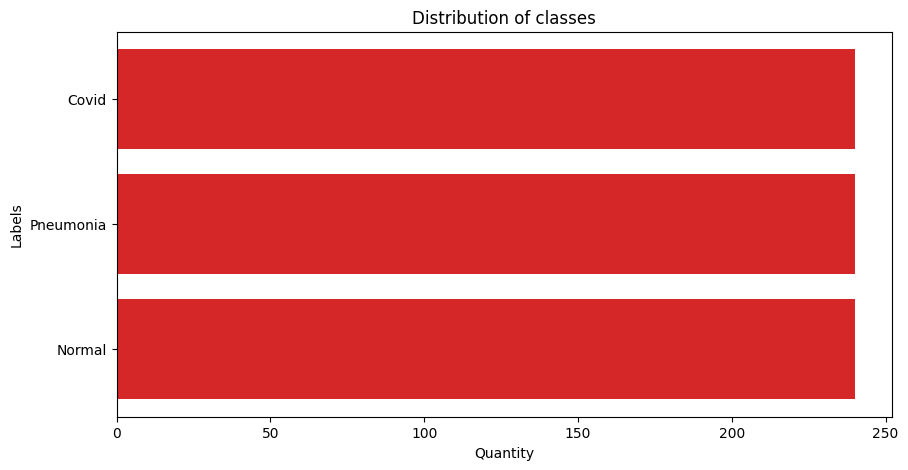

In [9]:
class_names =  ['NORMAL', 'PNEUMONIA', 'COVID']
dist = {}
quant = {}
        
for class_name in class_names:
    quant[class_name] = [x for x in os.listdir(dict_dataset('/content/drive/MyDrive/DATA/diseases/train')[class_name]) if x[-3:].lower().endswith('png')]
    dist[class_name.replace('_', ' ').capitalize()] = len(quant[class_name])

courses = list(dist.keys())
values = list(dist.values())
  
fig = plt.figure(figsize=(10, 5))
plt.barh(courses, values, color='tab:red')

plt.title("Distribution of classes")
plt.xlabel("Quantity")
plt.ylabel("Labels")
plt.show()

In [10]:
class_names = train_dataset.classes_list

def visualization(images, labels, preds):
    plt.figure(figsize=(20,10))
    for i, image in enumerate(images):
        plt.subplot(1, 6, i + 1, xticks=[], yticks=[])
        image = image.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = image * std + mean
        image = np.clip(image, 0., 1.)
        plt.imshow(image)
        col = 'green'
        if preds[i] != labels[i]:
            col = 'red'
        plt.xlabel('Actual :' f'{class_names[int(labels[i].numpy())]}',color='green')
        plt.text(9, 20, 'Pred :'f'{class_names[int(preds[i].numpy())]}',fontsize = 15, color='white', bbox={
        'facecolor': col, 'alpha': 0.5, 'pad': 10})    
        # plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color=col)
    plt.tight_layout()
    plt.show()


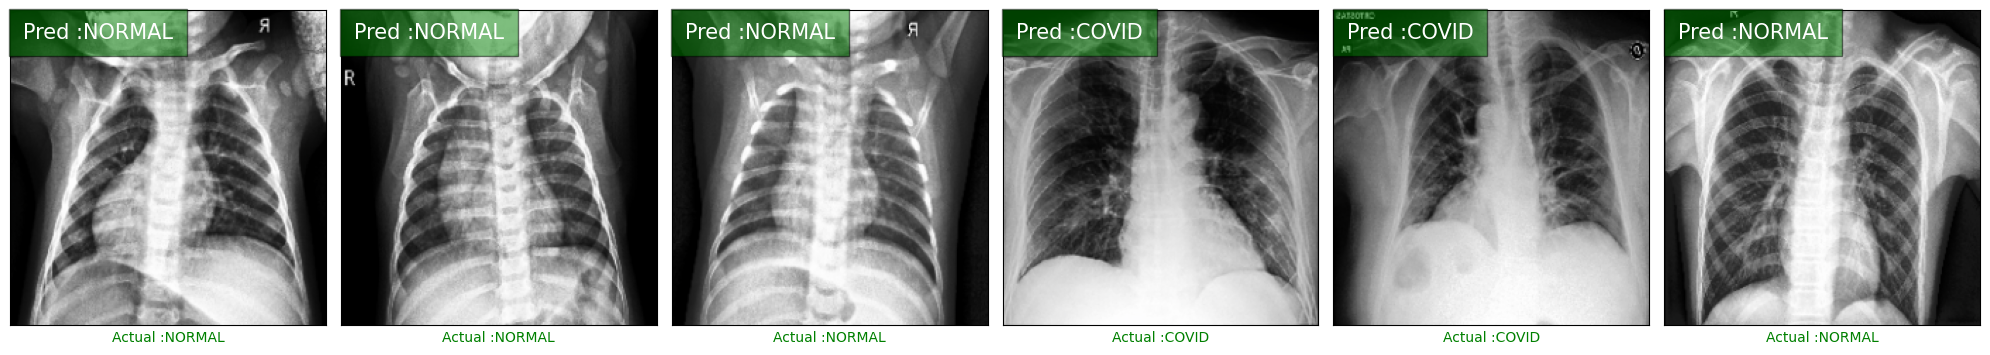

In [11]:
images, labels = next(iter(train_dl))
visualization(images, labels, labels)

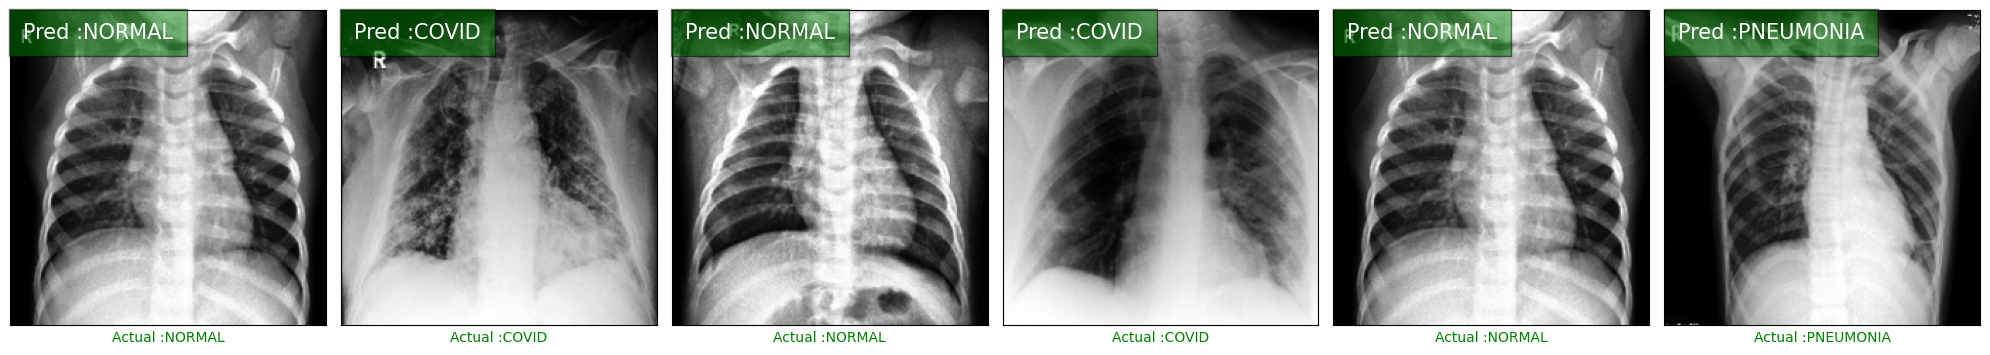

In [12]:
images, labels = next(iter(test_dl))
visualization(images, labels, labels)

In [41]:
model = torchvision.models.resnet18(pretrained=True)
print(model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [14]:
model.fc = torch.nn.Linear(in_features=512, out_features=3)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-5)

In [15]:
model.cuda().eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [16]:
def visualization_preds():
    model.cuda().eval()
    images, labels = next(iter(test_dl))
    outputs = model(images.cuda())
    _, preds = torch.max(outputs, 1)
    visualization(images.cpu(), labels.cpu(), preds.cpu())

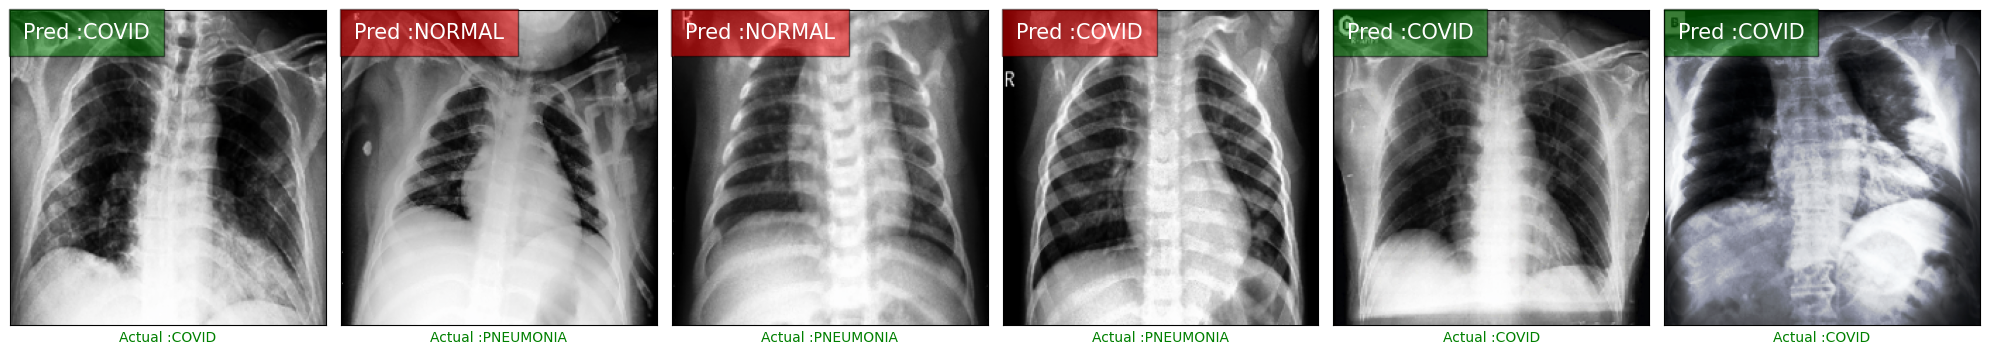

In [17]:
visualization_preds()

In [18]:
def train(epochs):
    print('Starting training..')
    for e in range(0, epochs):
        print('='*20)
        print(f'Starting epoch {e + 1}/{epochs}')
        print('='*20)

        train_loss = 0.
        val_loss = 0.

        model.train() 

        for train_step, (images, labels) in enumerate(train_dl):
            optimizer.zero_grad()
            outputs = model(images.cuda())
            loss = loss_fn(outputs, labels.cuda())
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            if train_step % 20 == 0:
                print('Evaluating at step', train_step)

                accuracy = 0

                model.eval() 

                for val_step, (images, labels) in enumerate(test_dl):
                    outputs = model(images.cuda())
                    loss = loss_fn(outputs, labels.cuda())
                    val_loss += loss.item()

                    _, preds = torch.max(outputs, 1)
                    accuracy += sum((preds == labels.cuda()).cpu().numpy())

                val_loss /= (val_step + 1)
                accuracy = accuracy/len(test_dataset)
                print(f'Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}')

                visualization_preds()

                model.train()

                if accuracy >= 0.98:
                    print('Performance condition satisfied, stopping..')
                    return

        train_loss /= (train_step + 1)

        print(f'Training Loss: {train_loss:.4f}')
    print('Training complete..')

Starting training..
Starting epoch 1/1
Evaluating at step 0
Validation Loss: 1.2292, Accuracy: 0.2111


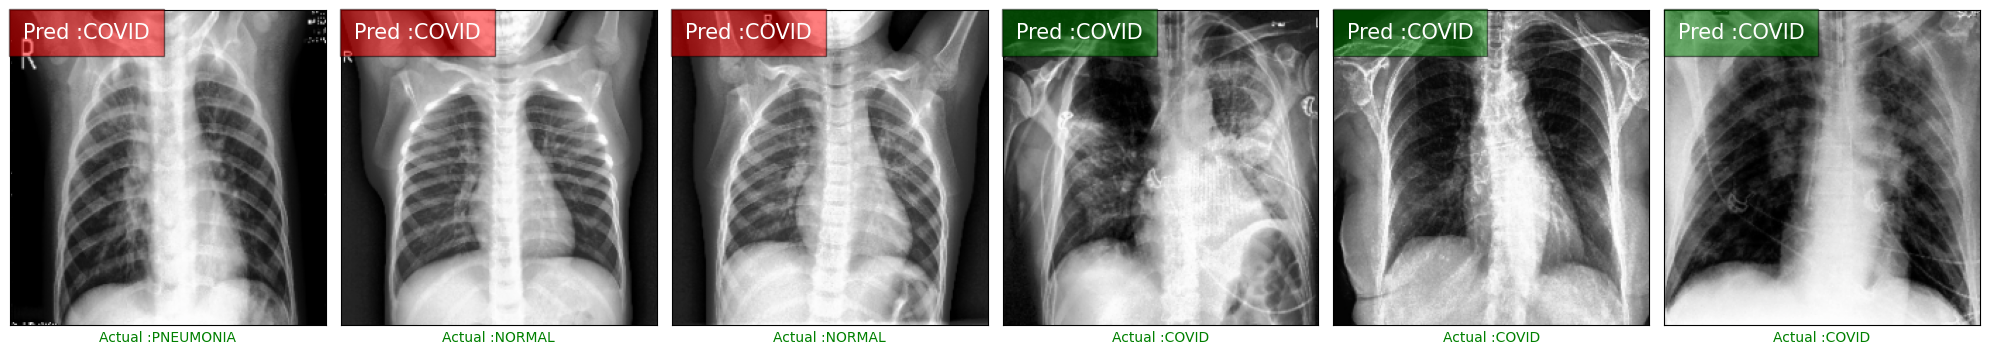

Evaluating at step 20
Validation Loss: 0.6000, Accuracy: 0.7833


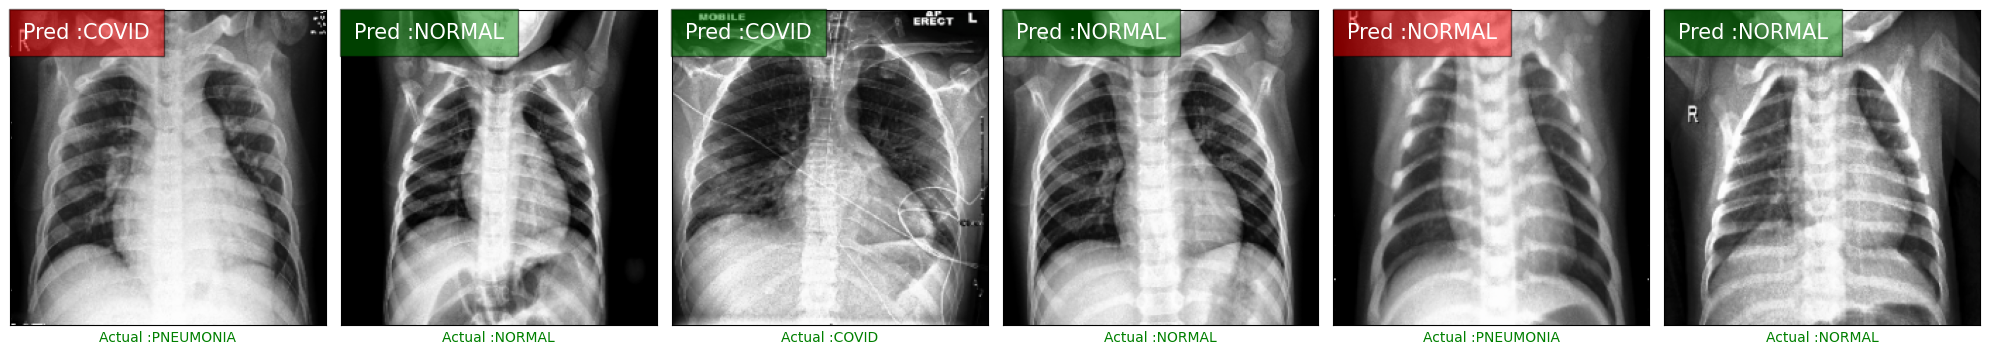

Evaluating at step 40
Validation Loss: 0.3808, Accuracy: 0.8778


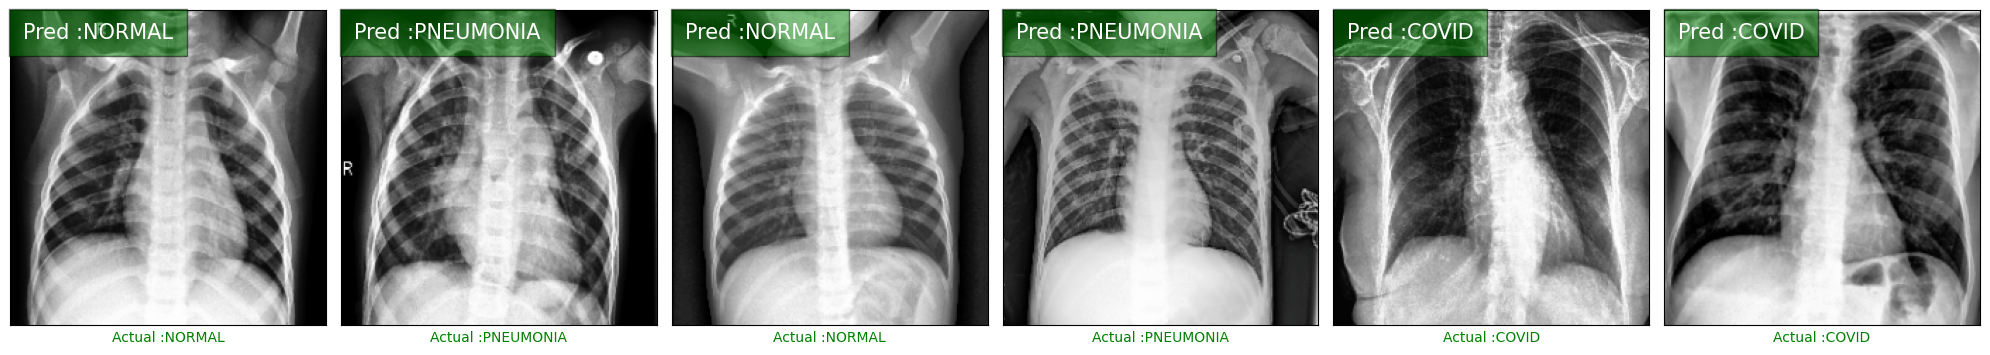

Evaluating at step 60
Validation Loss: 0.2437, Accuracy: 0.9333


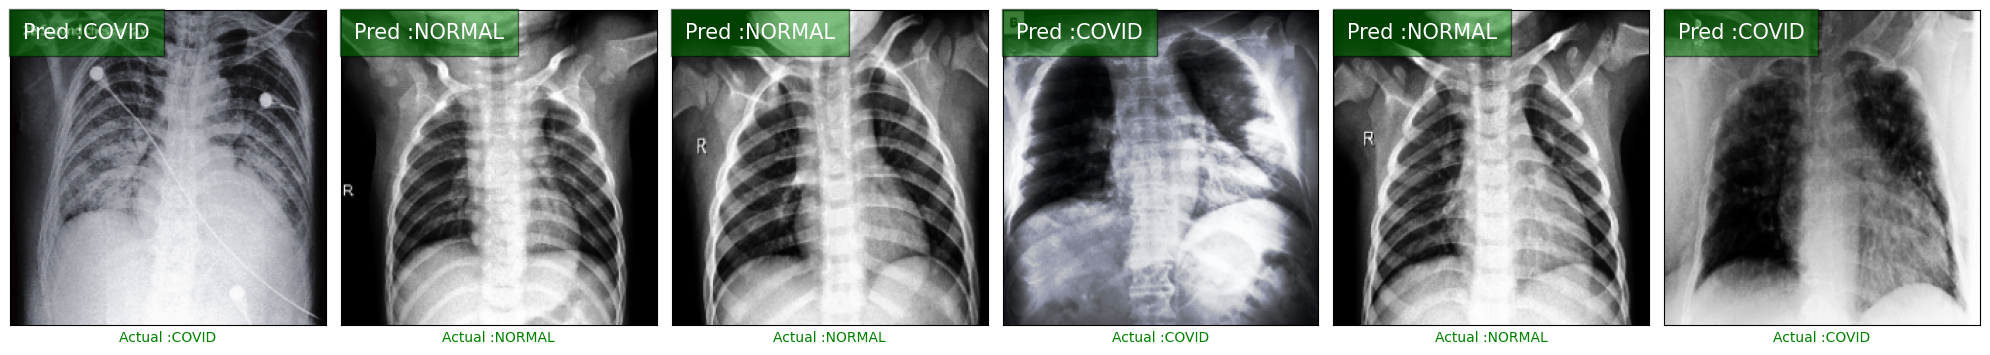

Evaluating at step 80
Validation Loss: 0.1654, Accuracy: 0.9778


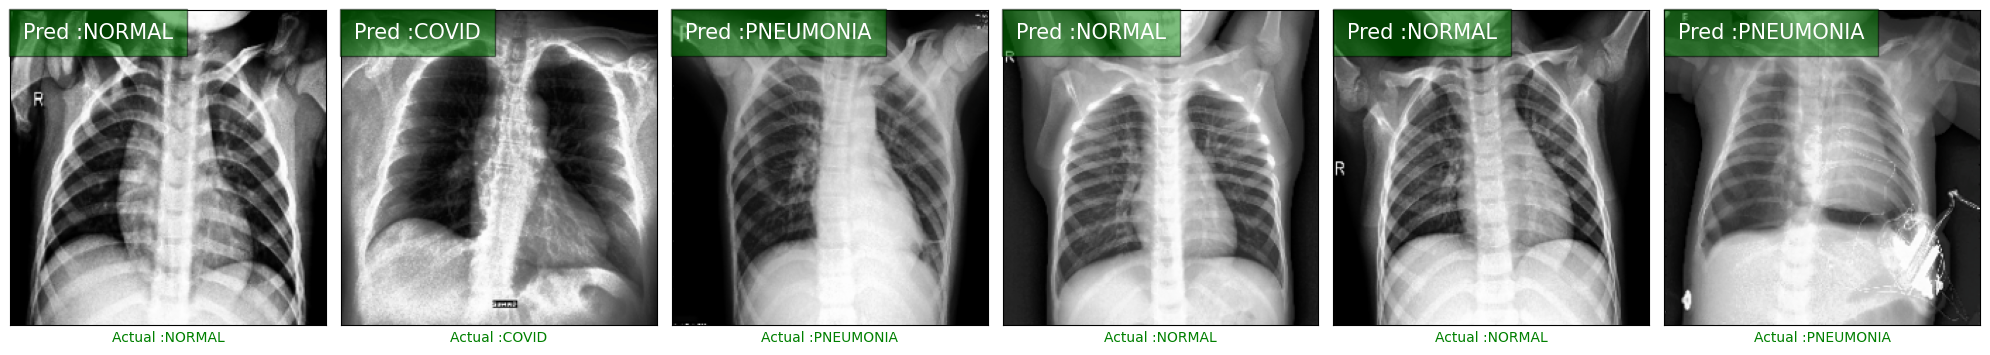

Evaluating at step 100
Validation Loss: 0.1842, Accuracy: 0.9500


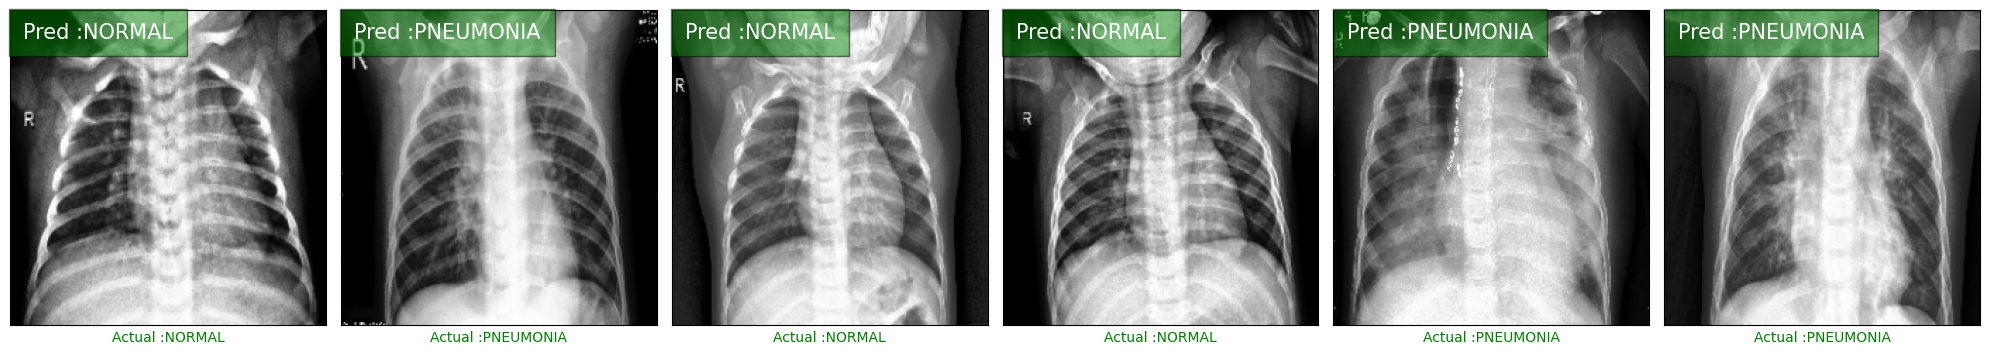

Training Loss: 0.4533
Training complete..
CPU times: user 23.9 s, sys: 1.38 s, total: 25.3 s
Wall time: 29.8 s


In [19]:
%%time

train(epochs=1)

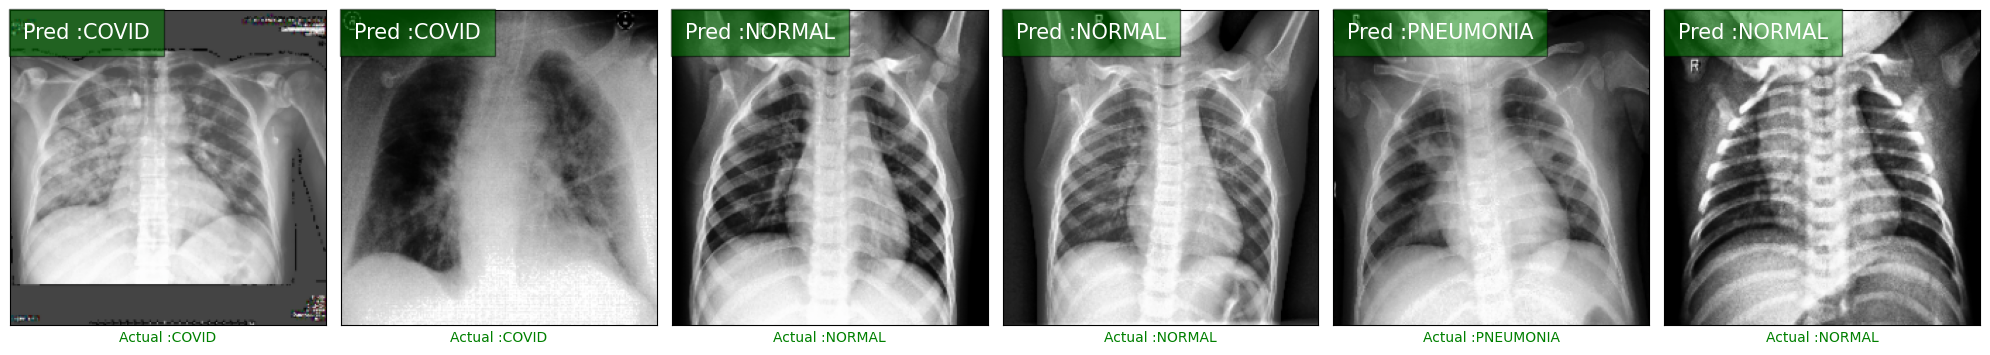

In [21]:
visualization_preds()


In [22]:
torch.save(model.state_dict(),'expand_ai_covid.pth')


In [23]:
s = torch.jit.script(model)
torch.jit.save(s,'expand_ai_covid.pt')

In [43]:
model = torch.load('expand_ai_covid.pt')


/usr/local/lib/python3.10/dist-packages/torch/serialization.py:799: UserWarning: 'torch.load' received a zip file that looks like a TorchScript archive dispatching to 'torch.jit.load' (call 'torch.jit.load' directly to silence this warning)
  warnings.warn("'torch.load' received a zip file that looks like a TorchScript archive"


In [50]:
classes =('NORMAL', 'PNEUMONIA', 'COVID')
test_pred_labels = []
test_true_labels = []
train_pred_labels = []
train_true_labels = []
ps_list = []
ps_list_train = []
running_correct = 0.0
running_total = 0.0
running_correct_train = 0.0
running_total_train = 0.0
accuracy_test=0.0
accuracy_train=0.0

import torch.nn.functional as F

def data_extraction(pred_label,true_label,ps_label,dataset,correct,total,accuracy):
    with torch.no_grad():
        for images, labels in dataset:
            model.cuda().eval()
            output = model(images.cuda())
            ps = F.softmax(output, dim=1)
            output = (torch.max(torch.exp(output.cpu()), 1)[1]).numpy()
            pred_label.extend(output)
            labels = labels.numpy()
            true_label.extend(labels)
            #ps = ps.data.cpu().numpy().squeeze()
            #ps_label.extend(np.max(ps))
            total += len(labels)
            correct += (output == labels).sum().item()
        accuracy = correct/total
        return pred_label,true_label,ps_label,dataset,correct,total,accuracy

In [54]:
one=data_extraction(test_pred_labels,test_true_labels,ps_list,test_dl,running_correct,running_total,accuracy_test)
print(one[1])
print(one[0])
target_test = torch.tensor(one[1])
preds_test = torch.tensor(one[0])
confmat = ConfusionMatrix(task='multiclass', num_classes=3)
mat_tensor = confmat(preds_test, target_test)
print(mat_tensor)


[0, 2, 0, 1, 0, 0, 1, 1, 2, 2, 0, 1, 1, 2, 2, 2, 0, 2, 1, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 1, 2, 0, 2, 1, 1, 2, 2, 0, 2, 2, 1, 2, 0, 0, 1, 1, 2, 2, 0, 0, 0, 1, 2, 1, 1, 2, 1, 0, 2, 1, 2, 0, 1, 2, 0, 0, 2, 1, 0, 2, 2, 1, 2, 1, 1, 0, 0, 0, 0, 0, 0, 2, 1, 2, 1, 1, 0, 0, 2, 2, 2, 0, 0, 1, 1, 2, 1, 0, 2, 1, 1, 0, 2, 1, 1, 1, 1, 0, 2, 2, 1, 2, 1, 1, 1, 0, 2, 0, 1, 2, 1, 2, 2, 2, 1, 1, 2, 1, 2, 0, 1, 0, 2, 2, 2, 1, 2, 1, 0, 1, 0, 0, 2, 0, 1, 1, 2, 0, 2, 2, 2, 2, 2, 1, 1, 1, 0, 0, 2, 1, 1, 1, 0, 0, 0, 2, 0, 1, 1, 2, 2, 0, 2, 0, 2, 0, 1, 2, 2, 1, 1, 0, 1, 1, 2, 1, 0, 1, 0, 2, 1, 0, 1, 2, 1, 1, 1, 0, 1, 2, 0, 2, 0, 0, 2, 1, 0, 2, 0, 2, 1, 2, 2, 2, 2, 0, 1, 1, 1, 2, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 1, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 1, 0, 0, 0, 0, 2, 2, 1, 0, 2, 2, 2, 2, 0, 2, 0, 2, 0, 0, 0, 1, 2, 2, 1, 1, 1, 2, 0, 0, 1, 0, 0, 1, 1, 1, 1, 2, 2, 0, 0, 0, 2, 0, 1, 2, 1, 2, 0, 1, 0, 2, 2, 1, 2, 0, 1, 0, 0, 0, 2, 0, 1, 0, 1, 1, 2, 0, 1, 0, 1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 

In [56]:
two=data_extraction(train_pred_labels,train_true_labels,ps_list_train,train_dl,running_correct_train,running_total_train,accuracy_train)

target_train = torch.tensor(two[1])
preds_train = torch.tensor(two[0])
confmat2 = ConfusionMatrix(task='multiclass', num_classes=3)
mat_tensor2 = confmat2(preds_train, target_train)

print(mat_tensor2)

tensor([[242,   6,   2],
        [  7, 229,   3],
        [  0,   3, 228]])


In [57]:
print("Total Correct Images: {}, Total Test Images: {}".format(int(one[4]), int(one[5])))
print("Test Accuracy: ", one[6])

Total Correct Images: 175, Total Test Images: 180
Test Accuracy:  0.9722222222222222


In [58]:
print("Total Correct Images: {}, Total Train Images: {}".format(int(two[4]), int(two[5])))
print("Test Accuracy: ", two[6])

Total Correct Images: 699, Total Train Images: 720
Test Accuracy:  0.9708333333333333


In [68]:
import seaborn as sns

def confutio(mat_tensor,name):
    conf_mat = mat_tensor.numpy()
    group_names = ['True Pos Normal','False Neg','False Neg','False Neg',
                   'False Neg','True Pos Lung','False Neg','False Neg',
                   'False Neg','False Neg','True Pos Pneumonia','False Neg',
                   'False Neg','False Neg','False Neg','True Pos COVID']
    group_counts = ["{0:0.0f}".format(value) for value in
                    conf_mat.flatten()]
    print(group_counts)
    group_percentages = ["{0:.2%}".format(value) for value in
                         conf_mat.flatten()/np.sum(conf_mat)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(3,3)
    fig, ax = plt.subplots(figsize=(10,10))
    ax=sns.heatmap(conf_mat, annot=labels, fmt='',ax=ax)
    ax.set_title(label=name+' Confussion Matrix')
    ax.plot
    fig.savefig(name+'_confussion.png')

['233', '12', '0', '12', '211', '0', '0', '5', '247']


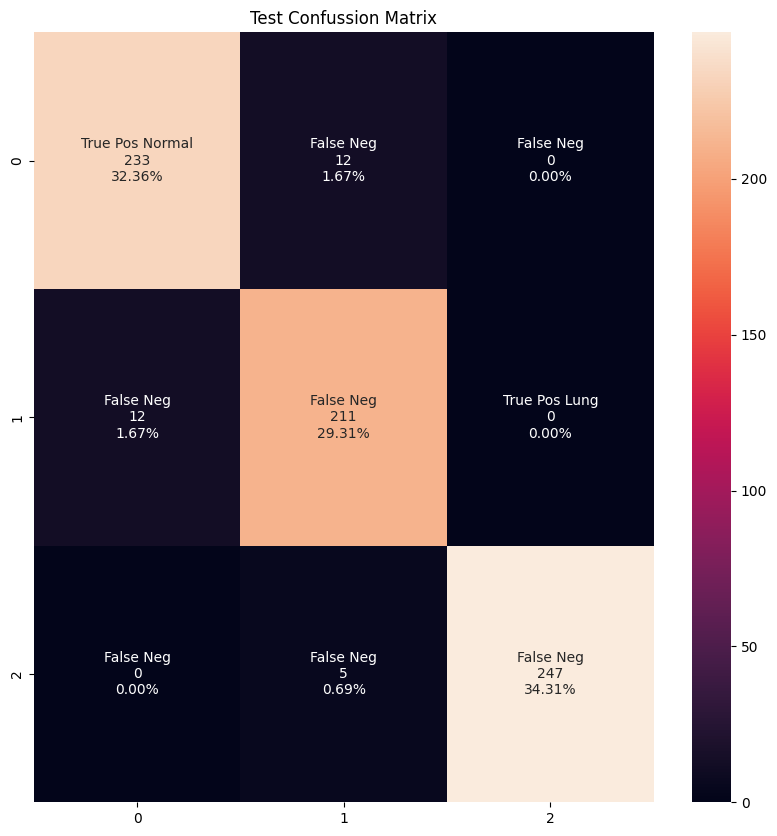

In [69]:
confutio(mat_tensor,'Test')

['242', '6', '2', '7', '229', '3', '0', '3', '228']


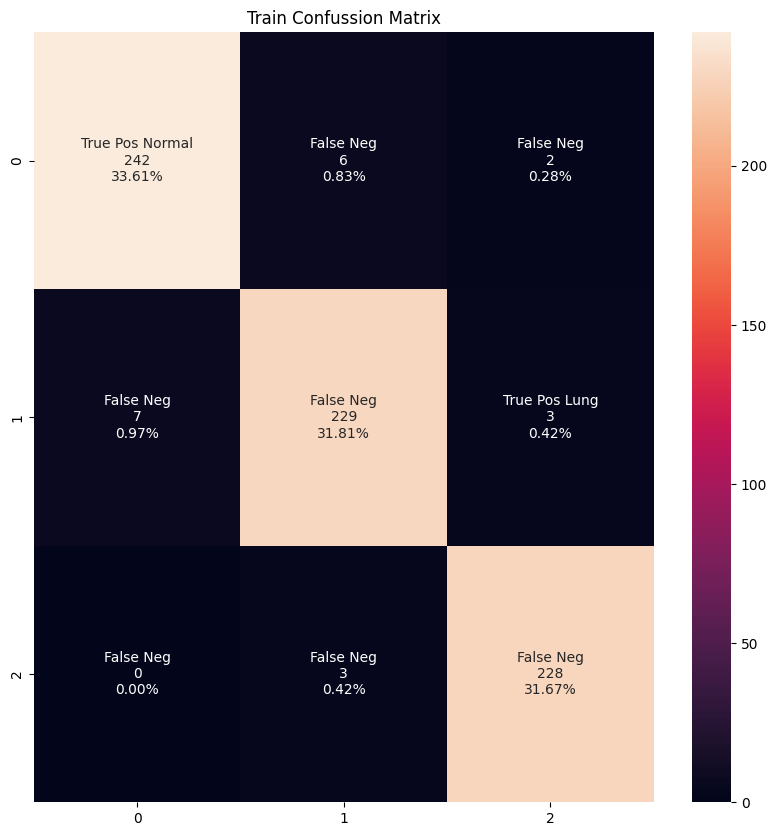

In [70]:
confutio(mat_tensor2,'Train')


In [71]:
import sklearn.metrics as metrics
print("Classification report for test set:\n%s\n"
      % (metrics.classification_report(one[1], one[0],target_names=['NORMAL', 'PNEUMONIA', 'COVID'])))

print("Classification report for train set:\n%s\n"
      % (metrics.classification_report(two[1], two[0],target_names=['NORMAL', 'PNEUMONIA', 'COVID'])))

Classification report for test set:
              precision    recall  f1-score   support

      NORMAL       0.95      0.95      0.95       245
   PNEUMONIA       0.93      0.95      0.94       223
       COVID       1.00      0.98      0.99       252

    accuracy                           0.96       720
   macro avg       0.96      0.96      0.96       720
weighted avg       0.96      0.96      0.96       720


Classification report for train set:
              precision    recall  f1-score   support

      NORMAL       0.97      0.97      0.97       250
   PNEUMONIA       0.96      0.96      0.96       239
       COVID       0.98      0.99      0.98       231

    accuracy                           0.97       720
   macro avg       0.97      0.97      0.97       720
weighted avg       0.97      0.97      0.97       720


